<a href="https://colab.research.google.com/github/3minuterecord/myJup/blob/master/MTG_GPT_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Fine Tune GPT-2 for Safety Incident Narrative Generation.

Use [PyTorch](https://pytorch.org/) and Transformers from [Hugging Face](https://huggingface.co/) to fine tune a [GPT-2 Model](https://openai.com/blog/gpt-2-1-5b-release/) to fabricate fake 'topic specific' incident descriptions. The intention is to use these fabricated incident descriptions to augment training data for supervised topic classification models.

Code chunk references:
- [Rey Farhan](http://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/)
- [Chris McCormick's](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) BERT fine-tuning tutorial
- [Ian Porter's](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) GPT2 tutorial 
- [Hugging Face](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) Language model fine-tuning script.

In [4]:
# Mount Google drive to access datasets.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


### Load Data & Support Packages

- Install the Huggingface transformers library. 
- Installing transformers will also install tokenizers (a dependency and another useful set of tools for this task).

In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 15.5 MB/s 
     |████████████████████████████████| 6.6 MB 78.6 MB/s 
     |████████████████████████████████| 120 kB 84.8 MB/s 


In [23]:
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel, GPT2Config
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch
torch.manual_seed(42)
from torch.utils.data import Dataset # this is the pytorch class import
from torch.utils.data import random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import numpy as np
import pandas as pd
import re
import pickle
import random

import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime
from tqdm.std import tqdm

In [8]:
# Topic-specific datasets were created using the rule-book classification method
# in a previous analysis step. We are interested here in topics that are rare but
# inportant as they are safety leading indicators (SLIs)
focus = 'hydraulic fluid or oil leak'
dataset_names = [
    'hydraulic fluid or oil leak_577_out_df_temp',
    'site compliance or practice issue_222_out_df_temp'
]

# Let's start with the **hydraulic fluid or oil leak** dataset.
sample_name = 'df_train_trues' #dataset_names[0]
reports = pd.read_csv(f"data/prepared/{sample_name}.csv", dtype=str)  

In [9]:
# Filter out rows that are not classified as the topic of interest 
# and remove unecessary columns.
reports = reports[reports.category != '*** Not Classified']
reports = reports[['text']]
reports = reports['text']
reports

0      robodrill spider excavator being operated when...
1      fuel red diesel spilled onto whiterockdirt sur...
2      oil leak from crane that was on site for plann...
3      small oil spill on twenty-one thousand and twe...
4      spider excavator hyd leak to soil 10ml spider ...
                             ...                        
465    struck by discharged object or substance an em...
466    injured by slipping or swinging object held by...
467    struck by swinging part of powered vehicle an ...
468    caught in running equipment or machinery durin...
469    struck against object or equipment unspecified...
Name: text, Length: 470, dtype: object

In [10]:
# Print a radom example as a spot check
select_random_row = random.randint(0, len(reports))
reports.iat[select_random_row]

'hydraulic fluid leak to soil 50ml approx from failed hose on skidsterer loader hydraulic fluid leak to soil of approx 50ml from a failed hydraulic hose on skidsteer loader pp205 leak contained with contaminated material removed for disposal machine to be inspected and repaired'

### GPT2 Tokenizer


What is a Tokenizer? (Ref. [Tokenizers](https://github.com/huggingface/tokenizers))
```
A Tokenizer works as a pipeline, it processes some raw text as input and outputs an Encoding. The various steps of the pipeline are:

- The Normalizer: in charge of normalizing the text. Common examples of normalization are the unicode normalization standards, such as NFD or NFKC.
- The PreTokenizer: in charge of creating initial words splits in the text. The most common way of splitting text is simply on whitespace.
- The Model: in charge of doing the actual tokenization. An example of a Model would be BPE or WordPiece.
- The PostProcessor: in charge of post-processing the Encoding to add anything relevant that, for example, a language model would need, such as special tokens.
```

Start by using the GPT-2 tokenizer to tokenize the report text data. The defaults of this function set the bos (beginning of sentence) eos (end of sentence) to '<|endoftext|>' but this can be set differently to differentiate and also assign a non-default pad token that will take care of white space for differently sized text. 

In [11]:
# Instantiate our tokenizer 
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

# Generate an example encoding
# Example string is encoded by the GPT2 tokenizer to a list of numerical values that represent the 
# string, in this case one numeric value per word. These values are easier to train the 
# neural network model on than the string representation.
tokenizer.encode("Sample Text")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[36674, 8255]

In [51]:
# Inspect to find the longest string, this is required later to determine pad length for sentences.
max_report = max([len(tokenizer.encode(report)) for report in reports])
print(f'The longest report text is {max_report} tokens long.')

The longest report text is 794 tokens long.


### PyTorch Datasets & Dataloaders

Different language models require different amounts of memory to hold all of the weights and biases in memory. The memory available will impact batch size.  

In [52]:
!nvidia-smi

Mon Sep 12 14:04:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    32W / 250W |   1483MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [53]:
# Model requires significant memory, start with batch size equal to 1
# TODO - Investigate why sucg a large memory requirement.
bs = 1

Batch size affects training time so better to set the batch to the highest number that can be fit in the memory of the GPU used for training. However, BS should only affect training time but not model performance.

Now create a custom dataloader for the corpus following the [PyTorch](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) documentation.

In [54]:
class safety_dataset(Dataset):
  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_report):
    self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      """
      This loop will iterate through each entry in the safety text corpus.
      For each bit of text it will prepend it with the start of text token,
      then append the end of text token and pad to the maximum length with the 
      pad token. 
      """

      encodings_dict = tokenizer('<|startoftext|>' + txt + '<|endoftext|>', 
                                 truncation=True, 
                                 max_length=max_length, 
                                 padding="max_length")
      
      """
      Each iteration then appends either the encoded tensor to a list,
      or the attention mask for that encoding to a list. The attention mask is
      a binary list of 1's or 0's which determine whether the langauge model
      should take that token into consideration or not. 
      """
      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

TODO - Investigate the maximum length of tokens (768?) that the tokenizer can handle. To save space in the model we ususally only pad up to the longest string in our corpus and not the longest string the tokenizer can handle. 

Firstly, you might wonder is why we’re ensuring that we chop our strings at 768 characters. We’re going to be using gpt2-small in this chapter, which has that limitation due to its hidden dimensionality of 768 (if you want to use larger pre-trained models, then you can increase this: gpt2-medium/1024, gpt2-large/1280, gpt2-xl/1600). Of course, because this dataset is only tweets, we’re never going to bump up against the limit, but I thought I would I’d include it so you know to be aware of the limitation.

In [55]:
dataset = safety_dataset(reports, tokenizer, max_length=max_report)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
f'There are {train_size} samples for training, and {val_size} samples for validation testing'

'There are 423 samples for training, and 47 samples for validation testing'

Finally to illustrate what an entry in this dataset looks like below is a print out of the first encoded string. You can see that for every encoded word the model pays attention to we have a 1, then for the padding encodings (50258) we have a 0.

In [13]:
# Each entry in the dataset will be two tensors,
# - one which is the encoding for the string 
# - one which is the attention mask. 
# The dataset will then be split into the training and validation sets.
dataset[0]

(tensor([50257, 22609,   375, 20190, 19230, 22659,  1352,   852, 12228,   618,
         31489, 15830,  4054,   290,  2716,  1160,  4029,   286,  7409, 11711,
           284,  9559,   379,  6702,   530,  7319,   290, 17280,   319,   262,
          2681,   400,   286,   730,    65,   257, 34797, 31489, 15830,  4054,
           290,  2716,  1160,  4029,   286,  7409, 11711,   284,  9559,   319,
           262,  3857,   375, 20190, 19230, 22659,  1352,   379,   479,    79,
          2414,   319,   262,  5752,   477, 23543,  5696, 17565,   298, 21226,
           547, 29947,   286, 20431,   656,   262, 23543,  7030, 11668, 50256,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258, 50258,
         50258, 50258, 50258, 50258, 50258, 50258, 5

Next we will create the dataloader object which will feed the neural network, this combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset, see the official [documentation](https://pytorch.org/docs/1.1.0/_modules/torch/utils/data/dataloader.html) for further details. 

In [14]:
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = bs 
        )

# Finetune GPT2 Language Model

In [15]:
# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [16]:
# We wil create a few variables to define the training parameters of the model
# epochs are the training rounds
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 4
warmup_steps = 1e2
sample_every = 100

[AdamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) is the optimizer of choice for training many models, we will be using [Hugging Face's](https://huggingface.co/transformers/main_classes/optimizer_schedules.html) implementation and all of it's defaults, we will also set the number of epochs here, again as we are fine tuning, not retraining, we don't need to run very long models. 

In [17]:
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [18]:
"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""
total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = warmup_steps, num_training_steps = total_steps)

In [25]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:393: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [20]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(0, epochs):
    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()  

        outputs = model(b_input_ids, labels=b_labels, attention_mask = b_masks, token_type_ids=None)
        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1, 30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 423. Loss:0.6292929649353027. Time:0:00:15

Example output:  bipartisanvacapeltering the floor is well on his tray and using the tray to clean up his tray it will also be cleaned up and cleaned up to repair the system that resulted from a faulty fluid system this system will not happen for any other reason this employee was not using his tray correctly this employee did not use his tray correctly this employee has not correctly used his tray correctly this employee has not correctly used his tray correctly this employee will not use his tray properly this employee will not properly clean up the tray this employee did not use his tray correctly this employee was unaware he was using his tray to clean up the tray this employee did not clean up the tray it will also be cleaned up and cleaned up to replace any other leak in this company that resulted in a spill and leak the employee did not leak any additional fluid this employee was unaware of the leaked fluid contained the w

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 423. Loss:0.4931287467479706. Time:0:00:28

Example output:  increasingminor severity rating of minor vibration minor vibration was noticed on the driver and the other driver reported minor vibration to the emergency line emergency line and all other crew were notified of the minor vibration and minor vibration minor vibration was also reported to the emergency line emergency line and other crew were notified and initiated actions to respond to these minor vibration minor vibration was noticed on the driver and the other driver reported minor vibration to the emergency line emergency line and other crew were notified and initiated actions to respond to these minor vibration minor vibration was observed on the driver and the other driver reported minor vibration to the emergency line emergency line and other crew were notified and initiated actions to respond to these minor vibration minor vibration was observed on the driver and the other driver reported minor vibration to

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 423. Loss:0.1699272096157074. Time:0:00:41

Example output: day and approximately one ounce of hydraulic fluid in a vehicle incident 34114on scene immediately see detailed description


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 423. Loss:0.2099095582962036. Time:0:00:51

Example output:  Hanghydraulic fluid leaking from the front of the vehicle as a result of a hydraulic hose spilling from the hydraulic hose when the vehicle was parked on an elevated slope approximately 500mm from the main spill area approximately twelve litres contained within was cleaned up properly and returned to the appropriate area for disposal see detailed description
Average Training Loss: 1.055403671577467. Epoch time: 0:00:54
Validation loss: 0.6264448822178739. Validation Time: 0:00:01
Beginning epoch 2 of 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 423. Loss:0.5786837935447693. Time:0:00:10

Example output:  foodsan employee was loading a load onto an air tank when a boom broke releasing hydraulic oil from the air tank causing a loss of lubricated hydraulic fluid to leak from the air tank causing a loss of lubricated hydraulic fluid to spill approximately twelve ounces of hydraulic fluid was recovered immediately upon starting to remove the tank cap and spill clean up


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 423. Loss:0.37521228194236755. Time:0:00:21

Example output:  trailit was reported two large rotsphere had leaked hydraulic fluid from the ground an employee was checking pump on the ground to ensure hydraulic fluid is contained employee noticed that the pump was overfilled his right hand and finger were scraped and placed into bucket to minimize the amount that went to the employee finger the spill was contained by utilizing absorbent pads and oil to block out the spill from the employee belly and area


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 423. Loss:0.6142173409461975. Time:0:00:32

Example output: intendspider excavator failed when oil was injected with hydraulic fluid to grade three liters of fluid went to grade incident 38167spider excavator failed when oil was injected with hydraulic fluid to grade three liters of fluid went to grade supervisor who informed operator informed safety see detailed description


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 423. Loss:1.193129062652588. Time:0:00:43

Example output:  surroundthree hundred and sixteen hours were removed from thomas tex texherton at 4500 hours on thomas texherton incident 36494at thomas texherton a technician was installing a lighting switch on the switchback he noticed that the light did not fit into the controls it was immediately placed into place and the lighting was fixed at the switchback the technician was informed and the technician immediately stopped operations and began to repair his light fw
Average Training Loss: 0.501783685252317. Epoch time: 0:00:46
Validation loss: 0.6062725275120837. Validation Time: 0:00:01
Beginning epoch 3 of 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 423. Loss:0.6095996499061584. Time:0:00:10

Example output:  reflexnacap excavator suffered a hydraulic hose failure resulting in an amputation of the fingertip


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 423. Loss:0.193158820271492. Time:0:00:20

Example output:  displaysmall hydraulic leak on january 31st two thousand and sixteen at 1200am on january one thousand and sixteen at 1200am on january one thousand and sixteen at 1200am on january one thousand and sixteen at 1200am on january one thousand and sixteen at 1200am on january one thousand and sixteen at 1200am on january one thousand and sixteen at 1200am on january one thousand and sixteen at 1200am on january one thousand and sixteen at 1200am on january one thousand and sixteen at 1200am on january one thousand and sixteen at 1215am on january one thousand and sixteen at 1200am on january one thousand and sixteen at 1200am on january one thousand and sixteen at 1215am on january one thousand and sixteen at 1215am on january one thousand and sixteen at 11pm at seven hundred thousand, nine hundred and sixteen at two thousand, three hundred and thirty at one hundred and forty and forty, forty two thousand, two hundre

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 423. Loss:0.4863595962524414. Time:0:00:33

Example output:  pastoroil spilled from excavator onto ground resulting in approximately two litres lost to soil on arrival on site incident 37775on two million, four hundred and thirty-five thousand, nine hundred and eighty-five, seven hundred and forty-five employees attended site to conduct a prework screening around the construction of the excavator the excavator operator noticed approximately two litres spilled from the excavator into soil prior to the task being stopped supervisor initiated a cleanupall contaminated material removed for disposal


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 423. Loss:0.18629516661167145. Time:0:00:45

Example output:  illicitapproximately fifty-five gallons of hydraulic oil released to soil from excavator pp105 in northeast texas fifty-five gallons of hydraulic oil released to soil from excavator pp105 in northeast texas at approximately nine hundred and thirty pm it was noted that the rot was worse than usual due to a worn out hose on the underside of the hydraulic hose which the operator then utilized to wipe down and wipe the contaminated soil off of the soil the rot was contained quickly cleaned up and the contaminated soil placed into a tray and placed in a bag for appropriate disposal by the operator in the event the equipment was damaged in the process of repair the leak is estimated to have been approximately 50mm approximately 50l dispersed throughout the day
Average Training Loss: 0.4131201722749441. Epoch time: 0:00:49
Validation loss: 0.607606976907304. Validation Time: 0:00:01
Beginning epoch 4 of 4


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 423. Loss:0.4974361062049866. Time:0:00:10

Example output:  Liberationnacap subcontracted to subcontractor nacap subcontractor nacap subcontractor nacap subcontractor nacap subcontracted to subcontractor nacap subcontractor found out about the issue with nacap subcontractor discovered about the issue with nacap subcontractor notified maintenance to clean up subcontractor cleaned up nacap subcontractor notified maintenance to clean up subcontractor returned to work site repaired nacap subcontractor contacted to repair and returned to work


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 423. Loss:0.0688190832734108. Time:0:00:21

Example output:  Namoil leak from crane onto pavement while conducting pre work on the new stretch of runway for the project one employee opened a small hydraulic leak on the concrete surface before taking the spill to the hazmat team who quickly placed absorbent pads on the leak and notified area personnel one hse was called to duty today afternoon to begin an investigation using hazmat technician on the scene with the crane mechanical crew the leak was contained immediately with the exception of the crane that had suffered a hydraulic hose failure one employee was hospitalized for chemical exposure and the other employee was evacuated to a nearby hospital with mechanical failure


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 423. Loss:0.29098212718963623. Time:0:00:33

Example output: IONsmall hydraulic fluid leak from komo boom boom truck this afternoon a small hydraulic fluid leak from the komo boom truck this afternoon a small hydraulic fluid leak from the komo boom truck this afternoon a small hydraulic fluid leak from the komo boom truck this afternoon a small hydraulic fluid leak from the komo boom truck this afternoon a small hydraulic fluid leak from the komo boom truck this afternoon a small hydraulic fluid leak from the komo boom truck this afternoon a small hydraulic fluid leak from the komo boom truck this afternoon a small hydraulic fluid leak from the komo boom truck this afternoon a small hydraulic fluid leak from the komo boom truck this afternoon a small hydraulic fluid leak from the komo boom truck this afternoon a small hydraulic fluid leak from the komo boom truck this afternoon a small hydraulic fluid leak from the komo boom truck this afternoon a small hydraulic fluid lea

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 423. Loss:0.6212562918663025. Time:0:00:46

Example output:  glimpsea thirdparty site that was being utilized by two incident 3990on friday january sixteen two thousand and twenty-one at one thousand, four hundred and thirty pm at basf freeport a tow truck was hired to load the crane onto the crane stands at the entrance to the freeport b 1200e park a thirdparty site was utilized by two local brazos to load the crane onto the crane stands at the entrance to the freeport b 1200e park a thirdparty site was utilized by two local brazos to load the crane onto the crane stands at the entrance to the freeport b 1200e park a thirdparty site was utilized by two local brazos to load the crane onto the crane stands at the entrance to the freeport b 1200e park a thirdparty site was utilized by two local brazos to load the crane onto the crane stands at the entrance to the freeport b 1200e park a thirdparty site was utilized by two local b
Average Training Loss: 0.33841363118684037. E

Let's view the summary of the training process, We'll visualize the change in training and validation loss to see if the models is converging. 

/bin/bash: matplotlib: command not found


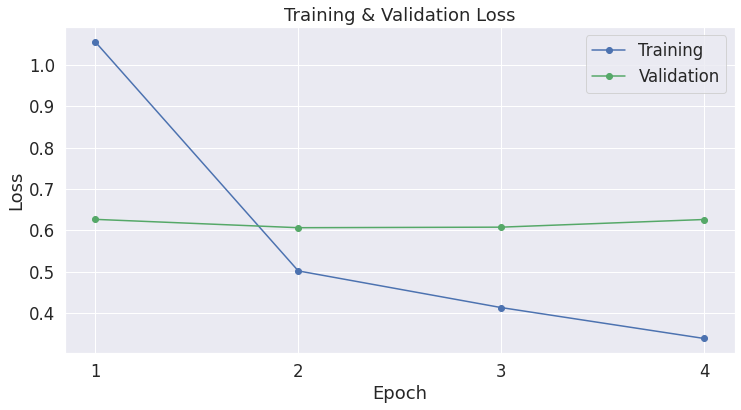

In [21]:
!matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [27]:
# Save the model
filename = f'output/models/{time.strftime("%y%m%d%H%M")}_{focus}_language_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

### Generate Fake Text

In [44]:
# Printing long descriptions in Colab can be messy as they down't wrap
# Create simple function to split lines to set length
def split_input(user_string, chunk_size):
    output = []
    words = user_string.split(" ")
    total_length = 0

    while (total_length < len(user_string) and len(words) > 0):
        line = []
        next_word = words[0]
        line_len = len(next_word) + 1

        while  (line_len < chunk_size) and len(words) > 0:
            words.pop(0)
            line.append(next_word)

            if (len(words) > 0):
                next_word = words[0]
                line_len += len(next_word) + 1

        line = " ".join(line)
        output.append(line)
        total_length += len(line) 

    return output

In [23]:
how_many_examples = 1
model.eval()
prompt = "<|startoftext|>"
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=how_many_examples
                                )

for i, sample_output in enumerate(sample_outputs):
    fab_txt = split_input(tokenizer.decode(sample_output, skip_special_tokens=True), 80)
    for r, chunk in enumerate(fab_txt):
        if r == 0:
            head_txt = f'\nFake {i+1}:'
            print(head_txt)
            print('-'*(len(head_txt)-1))
            print(chunk)    
        else:
            print(chunk)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Fake 1:
-------
spill of hydraulic fluid from equipment at wpc a two thousand, four hundred
and fifteen while carrying out maintenance work for gdc on site incident
39878at approximately one thousand, two hundred and forty-five pm on one
thousand, five hundred pm on the two thousand and forty-eight thousand, three
hundred and forty-seven this was a one thousand, two hundred and forty-seven
thousand, two hundred and forty-seven oil spill with no sign of mechanical
failure see detailed description


In [72]:
# load the model from disk
lang_model = pickle.load(open('output/models/2209120910_hydraulic fluid or oil leak_language_model.pkl', 'rb'))

In [160]:
prompts_file = pd.read_csv("rule_book/prompts.csv")

def clean_prompts(in_str):
    out_str = re.sub('\\[', '', in_str)
    out_str = re.sub('\\]', '', out_str)
    out_str = re.sub("'", '', out_str)
    out_str = out_str.split(", ")
    return(out_str)

prompts_list = clean_prompts(prompts_file['prompts'].iloc[0])

In [ ]:
#prompts_list = ['hyd failure', 'there was a leak']
all_fab_txts = []
ECHO=False
for p in tqdm(prompts_list):
    how_many_examples = 10
    lang_model.eval()
    prompt = "<|startoftext|>"+p
    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    sample_outputs = lang_model.generate(
                                    generated, 
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length=400,
                                    top_p=0.95, 
                                    num_return_sequences=how_many_examples,
                                    no_repeat_ngram_size=2,
                                    pad_token_id = tokenizer.eos_token_id
                                    )

    for i, sample_output in enumerate(sample_outputs):
        fab_txt = tokenizer.decode(sample_output, skip_special_tokens=True)
        all_fab_txts.append(fab_txt)
        if ECHO:
            fab_txt = split_input(fab_txt, 80)
            for r, chunk in enumerate(fab_txt):
                if r == 0:
                    head_txt = f'\nFake {i+1}:'
                    print(head_txt)
                    print('-'*(len(head_txt)-1))
                    print(chunk)    
                else:
                    print(chunk)

df_fab_txts = pd.DataFrame(all_fab_txts, columns = ['text'])
df_fab_txts['group'] = focus

 98%|█████████▊| 779/792 [42:05<00:41,  3.22s/it]

In [152]:
print('No. of fabricated reports: ', len(df_fab_txts))
df_fab_txts

,text,group
0,hyd failure of a hydraulic fitting on excavato...,hydraulic fluid or oil leak
1,hyd failure on boom truck at kopienda as it wa...,hydraulic fluid or oil leak
2,hyd failure on pump hose of truck three thousa...,hydraulic fluid or oil leak
3,there was a leak from the crane outriggers at ...,hydraulic fluid or oil leak
4,there was a leak of pressurized hydraulic flui...,hydraulic fluid or oil leak
5,there was a leak on the concrete surface of a ...,hydraulic fluid or oil leak


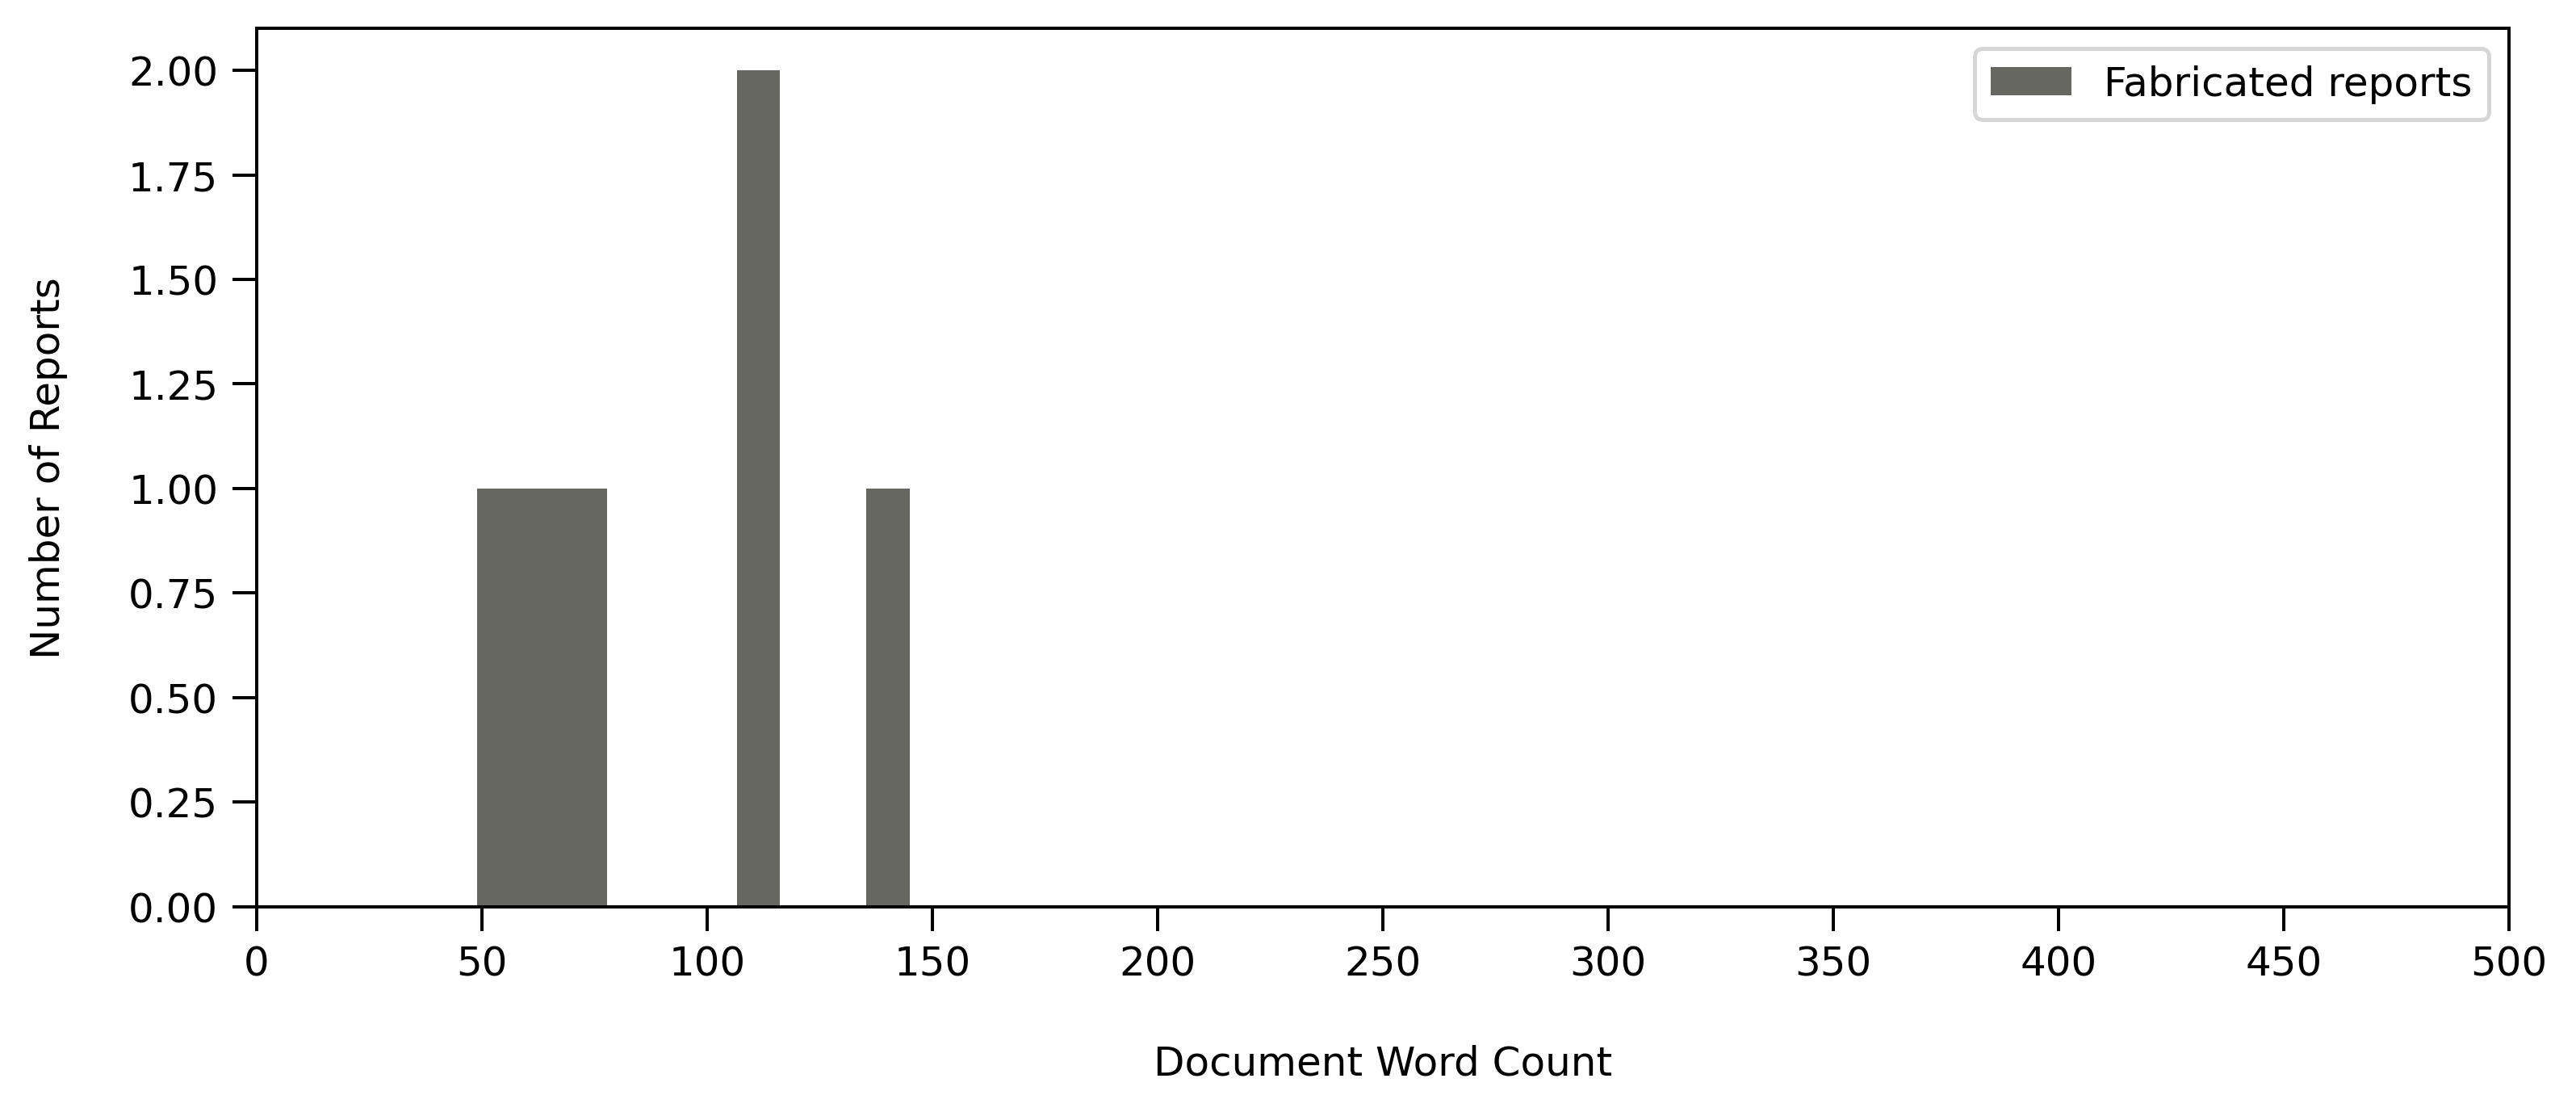

In [159]:
# Plot
doc_lens = [len(d.split()) for d in df_fab_txts.text]
plt.figure(figsize=(10, 4), dpi=360)
plt.hist(doc_lens, bins = 10, color='#26261e', alpha=0.7, label = 'Fabricated reports')
plt.legend(loc = 'upper right')

plt.xlabel("Document Word Count", labelpad = 15)
plt.ylabel("Number of Reports", labelpad = 15)
plt.tick_params(size=6)
plt.xticks(np.linspace(0, 500, 11))
plt.title('', fontdict=dict(size=10))
plt.show()

In [136]:
def gen_fake_reports(focus, lang_model, prompt_list, how_many=10, max_len=400):

    """
    Generate n fake reports per prompt. 
    """
    fake_count = len(prompt_list) * how_many
    print(f'Generating {"{:,}".format(fake_count)} fake reports...')
    lang_model.eval()
    all_fab_txts = []
    for p in prompt_list:
        prompt = f'<|startoftext|>{p}'
     
        generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
        generated = generated.to(device)
        sample_outputs = lang_model.generate(generated, 
                                        do_sample=True,   
                                        top_k=50, 
                                        max_len=max_len,
                                        top_p=0.95, 
                                        num_return_sequences=how_many
                                        )
        
        for i in range(len(sample_outputs)):
            fab_txts = tokenizer.decode(sample_outputs[i], skip_special_tokens=True)
            print(fab_txts)
            all_fab_txts.append(fab_txts)

    df_fab_txts = pd.DataFrame(all_fab_txts, columns = ['text'])
    df_fab_txts['group'] = focus

    return(df_fab_txts)

In [93]:
prompts_list = ['hyd failure', 'there was a leak']

In [137]:
df_fakes = gen_fake_reports(focus, lang_model, prompt_list=prompts_list, how_many=3, max_len=400)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generating 6 fake reports...


/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1207: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


hyd failure on skid steer at separation of skid steer between two pipe plinths incident
hyd failure on hose of pump arm resulting in 20l of hydraulic fluid leaking to grade incident 39
hyd failure on dow lift resulted in a loss of approximately 200ml of hyd fluid to soil of
there was a leak to grade on jlg today it is suspected that a line of hydraulic
there was a leak on the concrete pump of a d988 onto the concrete road a d
there was a leak on a bucket truck a maintenance employee was inspecting it when a hose came off


In [138]:
df_fakes

,text,group
0,hyd failure on skid steer at separation of ski...,hydraulic fluid or oil leak
1,hyd failure on hose of pump arm resulting in 2...,hydraulic fluid or oil leak
2,hyd failure on dow lift resulted in a loss of ...,hydraulic fluid or oil leak
3,there was a leak to grade on jlg today it is s...,hydraulic fluid or oil leak
4,there was a leak on the concrete pump of a d98...,hydraulic fluid or oil leak
5,there was a leak on a bucket truck a maintenan...,hydraulic fluid or oil leak


In [139]:
for t in df_fakes.text:
    print(len(t.split()))
    print(t)

15
hyd failure on skid steer at separation of skid steer between two pipe plinths incident
18
hyd failure on hose of pump arm resulting in 20l of hydraulic fluid leaking to grade incident 39
18
hyd failure on dow lift resulted in a loss of approximately 200ml of hyd fluid to soil of
17
there was a leak to grade on jlg today it is suspected that a line of hydraulic
17
there was a leak on the concrete pump of a d988 onto the concrete road a d
19
there was a leak on a bucket truck a maintenance employee was inspecting it when a hose came off
